# Online Style Transfer (by Johnson)

В этом ноутбуке мы реализуем метод, который позволит производить перенос стиля с невероятной скоростью. Ранее мы оптимизировали content и style loss по изображению. Здесь мы будем оптимизировать этот же loss, но не по изображению, а по параметрам специальной нейронной сети, которая на вход получает изображение контента, а на выходе генерирует стилизованное изображение.

In [1]:
from tqdm import tqdm_notebook as tqdm
from tensorboardX import SummaryWriter

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision as tv
import torchvision.transforms as ts

from PIL import Image
from glob import glob
import numpy as np

import sys
import os

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# определяем вспомогательные функции,
# аналогичные тем, что мы видели ранее

def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    img = img.convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        new_width = int(img.width * scale)
        new_height = int(img.height * scale)
        img = img.resize((new_width, new_height), Image.ANTIALIAS)
    return img

def to_image(data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    return Image.fromarray(img)


def gram_matrix(y):
    fs_0 = y.view(y.shape[0], y.shape[1], -1)
    fs_1 = fs_0.transpose(1, 2)
    scale = 1 / (y.shape[1] * y.shape[2] * y.shape[3])
    return th.bmm(fs_0, fs_1).mul(scale)


def normalize_batch(batch):
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(1,-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(1,-1, 1, 1)
    batch = batch.div(255.0)
    return (batch - mean) / std

In [3]:
# перейдем к реализации сети, которая будет переводить 
# изображение контента в стилизованное изоражение

# схематично, сеть состоит из трёх компонент:
# * features -- извлекает релевантные признаки из входного изображения,
#   производя при этом небольшое уменьшение размерности (в 4 раза)
# * residual_blocks -- производяет некоторую "переработку" внутреннего
#   представления сетью изображения
# * upsampling -- возвращение размерности изображения к исходному

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.features = nn.Sequential(
            nn.ReflectionPad2d(4), nn.Conv2d(3, 32, kernel_size=9), nn.InstanceNorm2d(32), nn.ReLU(),
            nn.ReflectionPad2d(1), nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.InstanceNorm2d(64), nn.ReLU(),
            nn.ReflectionPad2d(1), nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.InstanceNorm2d(128), nn.ReLU())
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128))
        self.upsampling = nn.Sequential(
            UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2),
            nn.InstanceNorm2d(64, affine=True), nn.ReLU(),
            UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2),
            nn.InstanceNorm2d(32, affine=True), nn.ReLU(), 
            nn.ReflectionPad2d(4), nn.Conv2d(32, 3, kernel_size=9))

    def forward(self, x):
        x = self.features(x)
        x = self.residual_blocks(x)
        x = self.upsampling(x)
        return x

In [4]:
# ResidualBlock представляет собой аналог блока из ResNet
# с тем отличием, что во-первых, вместо BatchNormalization
# используется InstanceNormalization, а во-вторых, в свёртках
# применяется reflection pad вместо стандартного zero pad

class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3)
        self.inst1 = nn.InstanceNorm2d(num_channels, affine=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3)
        self.inst2 = nn.InstanceNorm2d(num_channels, affine=True)

    def forward(self, x):
        x_input = x
        x = th.relu(self.inst1(self.conv1(self.pad(x))))
        x = self.inst2(self.conv2(self.pad(x))) + x_input
        return x

In [5]:
# UpsampleConvLayer представляет собой композицию из двух операций:
# интерполяции изображений (т.е. ресайз в два раза) и применением свёртки
# с reflection padding-ом
    
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=2):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        self.pad = nn.ReflectionPad2d(kernel_size // 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x = F.interpolate(
            x, mode='nearest',
            scale_factor=self.upsample)
        x = self.conv(self.pad(x))
        return x

In [6]:
# для вычисления StyleLoss нам понадобится предобученная сеть,
# а точнее выходы с некоторых её слоёв -- для этого сделаем
# модель, которая как раз и будет возращать нам нужные активации

class VGG16(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16, self).__init__()

        model = tv.models.vgg16(pretrained=pretrained)
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:4])
        self.slice_1 = nn.Sequential(*layers[4:9])
        self.slice_2 = nn.Sequential(*layers[9:16])
        self.slice_3 = nn.Sequential(*layers[16:23])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        xs = []

        x = self.slice_0(x)
        xs.append(x)
        
        x = self.slice_1(x)
        xs.append(x)
        
        x = self.slice_2(x)
        xs.append(x)
        
        x = self.slice_3(x)
        xs.append(x)

        return xs

In [7]:
BATCH_SIZE = 4

device = th.device("cuda")

np.random.seed(42)
th.manual_seed(42)

transform = ts.Compose([
    ts.Resize(256),
    ts.CenterCrop(256),
    ts.ToTensor(),
    ts.Lambda(lambda x: x.mul(255))
])

# в директории ./coco есть директория ./images, содержащая изображения
# из валидационной выборки датасета COCO 2017 -- чтобы их проиндексировать,
# воспользуемся уже готовым ImageFolder датасетом, который затем 
# положим в DataLoader, чтобы эффективно итерироваться по батчам

train_dataset = tv.datasets.ImageFolder('./data/coco', transform)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

# создаим наш TransformerNet и передадим его параметры в распоряжение Adam-а
transformer = TransformerNet().to(device)
optimizer = optim.Adam(transformer.parameters(), 1e-3)

In [8]:
# создадим сеть-извлекатор признаков

vgg = VGG16().to(device)
style_transform = ts.Compose([
    ts.ToTensor(),
    ts.Lambda(lambda x: x.mul(255))
])

# выберем изображение-стиль и закешируем для него матрицы Грама
style = load_image('./data/style-transfer/styles/rain_princess.jpg')
style = style_transform(style)
style = style.repeat(BATCH_SIZE, 1, 1, 1).to(device)
gram_style = [gram_matrix(y) for y in vgg(normalize_batch(style))]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/alexey.kozinov/.torch/models/vgg16-397923af.pth
553433881it [00:05, 93489325.99it/s] 


In [9]:
# будем использовать TensorBoard для PyTorch
logdir = './logdir/rain_princess'
writer = SummaryWriter(logdir)

# чтобы поднять TensorBoard-сервер, через который мы будем смотреть
# на ход нашего обучения, нужно выполнить следующую команду:
# tensorboard --logdir ./logdir --port 9999
# указав директорию (или её родительскую), которую мы передали
# SummaryWriter-у, а так же нужно указать порт, через который мы
# затем сможем зайти нашим браузером

transformer.train()

step = 0

# 10K итераций вполне достаточно для получения неплохих результатов

for epoch in range(8):
    for x, _ in tqdm(train_loader):
        # обнуляем градиенты
        optimizer.zero_grad()

        # применяем сеть-transformer к изображению
        x = x.to(device)
        y = transformer(x)
        
        # VGG-сеть требует нормализацию каналов входных изображений
        y = normalize_batch(y)
        x = normalize_batch(x)

        # вычисляем признаки с нужных слоёв VGG
        features_y = vgg(y)
        features_x = vgg(x)

        # считаем content-loss
        content_loss = 1e5 * F.mse_loss(
            features_y[1], features_x[1])

        # считаем сумма style-loss-ов
        style_loss = 0.0
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = gram_matrix(ft_y)
            style_loss += F.mse_loss(gm_y, gm_s[:gm_y.shape[0], :, :])
        style_loss *= 1e10

        # считаем градиенты по общему loss-у
        total_loss = content_loss + style_loss
        total_loss.backward()

        # делаем шаг оптимизации
        optimizer.step()
        
        # логгируем результат в 
        writer.add_scalar("content_loss", content_loss.item(), step)
        writer.add_scalar("style_loss", style_loss.item(), step)
        writer.add_scalar("total_loss", total_loss.item(), step)
        
        step += 1

# сохраним веса модели, чтобы не обучать модель в следующий раз
th.save(
    transformer.state_dict(), 
    os.path.join(logdir, "state_dict.pth"))

In [10]:
# функция для красивой отрисовки сразу нескольких изображений
def images_to_canvas(images, columns=3, factor=1.0):
    ws = np.array([img.width for img in images])
    hs = np.array([img.height for img in images])

    ws = ws.reshape(-1, columns).min(axis=0)
    hs = hs.reshape(-1, columns).min(axis=1)
    
    canvas = Image.new('RGB', (ws.sum(), hs.sum()))
    
    for i, image in enumerate(images):
        canvas.paste(image, (
            ws[:i % columns].sum(), 
            hs[:i // columns].sum()))

    return canvas.resize((
        int(canvas.width * factor), 
        int(canvas.height * factor)
    ), Image.BICUBIC)


def visualize(*styles):
    final = []

    for name in styles:
        # создадим TransformerNet и загрузем в неё обученные веса
        ckpt = th.load(f'./logdir/{name}/state_dict.pth')
        transformer = TransformerNet().to(device).eval()
        transformer.load_state_dict(ckpt)

        # пропустим через сеть все наши изображения контента
        # и посмотрим, что получилось

        results = []
        for filepath in glob('./data/style-transfer/contents/*.jpg'):
            content_image = load_image(filepath, scale=0.6)
            content_transform = ts.Compose([
                ts.ToTensor(),
                ts.Lambda(lambda x: x.mul(255))
            ])
            content_image = content_transform(content_image)
            content_image = content_image.unsqueeze(0).to(device)

            with th.no_grad():
                output = transformer(content_image).cpu()

            results.append(to_image(output.squeeze(0)))

        final.append(images_to_canvas(results))

    return images_to_canvas(final, columns=2)    

In [11]:
visualize('sea', 'puantilism')

ValueError: cannot reshape array of size 8 into shape (3)

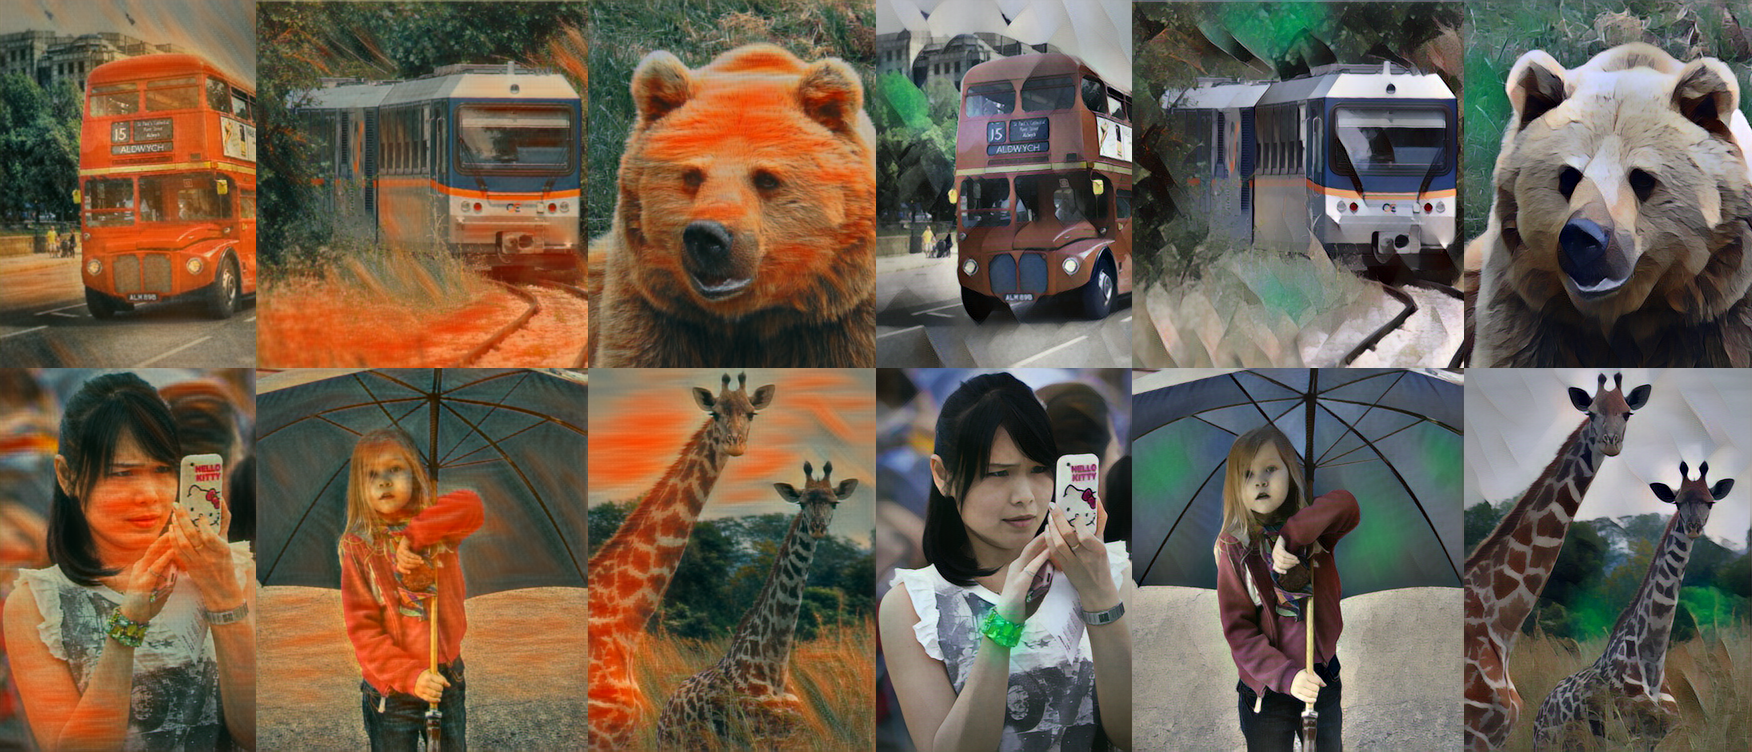

In [11]:
visualize('the_scream', 'udnie')